In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import scipy
import os
os.chdir('../')

/usr/local/anaconda3/envs/alpha-beta-crown/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def global_random_mask_from_ranks(ranks_list, ratios):
    shape_list = [layer.size() for layer in ranks_list]
    splitindex_list = np.cumsum([layer.numel() for layer in ranks_list]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    remain_ratio = sum(ratios)
    n = torch.cat([layer.flatten() for layer in ranks_list]).numel()
    index = np.random.permutation(n)[:round(remain_ratio*n)]
    mask = torch.zeros(n)
    mask[index] = 1
    # split flattened list and reshape accordingly
    mask_list = [mask[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    mask_list = [torch.reshape(mask_list[i], shape_list[i]) for i in range(len(ranks_list))]
    return mask_list

In [3]:
def scores_to_global_ranks_old(scores_list):
    # record shapes and number of elements for all layers
    shape_list = [layer.size() for layer in scores_list]
    splitindex_list = np.cumsum([layer.numel() for layer in scores_list]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    # flatten scores globally over all layers, rank and normalize
    all_scores = torch.cat([layer.flatten() for layer in scores_list])
    temp = torch.argsort(all_scores)
    ranks = torch.empty_like(temp)
    # replace score by rank
    ranks[temp] = torch.arange(len(temp))
    # min will always be 0 -> normalisation just division by max
    ranks = ranks / ranks.max()
    # split flattened list and reshape accordingly
    ranks_list = [ranks[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    ranks_list = [torch.reshape(ranks_list[i], shape_list[i]) for i in range(len(ranks_list))]
    return ranks_list

In [4]:
def scores_to_global_ranks(scores_list, method = 'min'):
    if method == 'argsort':
        return scores_to_global_ranks_old(scores_list)
    if method == 'norank':
        mi = min([l.min() for l in scores_list])
        ma = max([l.max() for l in scores_list])
        return [(l-mi)/(ma-mi) for l in scores_list]
    # record shapes and number of elements for all layers
    shape_list = [layer.size() for layer in scores_list]
    splitindex_list = np.cumsum([layer.numel() for layer in scores_list]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    # flatten scores globally over all layers, rank and normalize
    all_scores = torch.cat([layer.flatten() for layer in scores_list])

    ### RANKING AND NORMALISATION
    ranks = torch.Tensor(scipy.stats.rankdata(all_scores, method = method))
    ranks = ranks - ranks.min()
    ranks = ranks / ranks.max()

    # split flattened list and reshape accordingly
    ranks_list = [ranks[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    ranks_list = [torch.reshape(ranks_list[i], shape_list[i]) for i in range(len(ranks_list))]
    return ranks_list

In [5]:
def global_mask_from_ranks(inst_ranks, sig_ranks, gammas, ratios):
    assert len(inst_ranks) == len(sig_ranks), "Score lists have to be of same length"
    shape_list = [layer.size() for layer in inst_ranks]
    shape_list_alt = [layer.size() for layer in sig_ranks]
    assert shape_list == shape_list_alt, "Layerwise shapes have to be equal for both score lists"
    splitindex_list = np.cumsum([layer.numel() for layer in inst_ranks]).tolist()
    splitindex_list = [0] + splitindex_list[:-1]
    flat_inst_ranks = torch.cat([layer.flatten() for layer in inst_ranks])
    flat_sig_ranks = torch.cat([layer.flatten() for layer in sig_ranks])
    idcs = []
    for gamma, ratio in zip(gammas, ratios):
        # this is the case if we only ranks using instability score
        if gamma == float('+inf'):
            flat_scores = flat_inst_ranks
        else:
            flat_scores = gamma*flat_inst_ranks - flat_sig_ranks
        # already selected neurons are assigned -inf score to not be selected again
        flat_scores[idcs] = float('-inf')
        remain_count = round(ratio*flat_scores.numel())
        #print(f'grafting count: {remain_count} for gamma {gamma} and ratio {ratio}')
        new_idcs = torch.argsort(-flat_scores).tolist()[:remain_count]
        idcs += new_idcs
    # split flattened list and reshape accordingly
    mask = torch.zeros_like(flat_inst_ranks)
    mask[idcs] = 1
    mask_list = [mask[i:j] for i,j in zip(splitindex_list, splitindex_list[1:]+[None])]
    mask_list = [torch.reshape(mask_list[i], shape_list[i]) for i in range(len(mask_list))]
    return mask_list, idcs

In [6]:
def mask_list_to_idcs(mask_list):
    return torch.cat([layer.flatten() for layer in mask_list]).nonzero().flatten().tolist()

In [7]:
def jaccard_similarity(setA, setB):
    return len(setA.intersection(setB)) / len(setA.union(setB))

## Trying to reproduce provided mask


In [8]:
# CNNB PRETRAINED:
weights_path = "CNN-B_CIFAR10/Pretrained/Models/cnn_b_2_255_cifar10_baseline.pth"

grad_scores_path = 'CNN-B_CIFAR10/Pretrained/Own Scores/score_gradient.pth'
mag_scores_path = 'CNN-B_CIFAR10/Pretrained/Own Scores/score_magnitude.pth'
var_scores_path = 'CNN-B_CIFAR10/Pretrained/Own Scores/score_variance.pth'
inst_scores_path = 'CNN-B_CIFAR10/Pretrained/Own Scores/score_instability.pth'

## given mask:

given_mask_path = "CNN-B_CIFAR10/Pretrained/Mask/FAT_CNNB_eps2_255_graft_50_cifar.pt"

In [9]:
# unranked/unnormalised indicator values

grad_scores = torch.load(grad_scores_path)
mag_scores = torch.load(mag_scores_path)
var_scores = torch.load(var_scores_path)
inst_scores = torch.load(inst_scores_path)

given_mask = torch.load(given_mask_path)

### Trying all permutations of significance heuristic, significance value ranking method and instability value ranking method

0.7574846699531081
0.7574846699531081
0.7574846699531081
max jaccard similarity 0.6097 at params:
INST_RANK	SIG_RANK	HEUR
norank		min		SAP
norank		dense		SAP
dense		min		SAP
dense		dense		SAP


/var/folders/z5/yqd1shk93k5750y70gcq3tgw0000gn/T/ipykernel_29466/3247469936.py:34: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


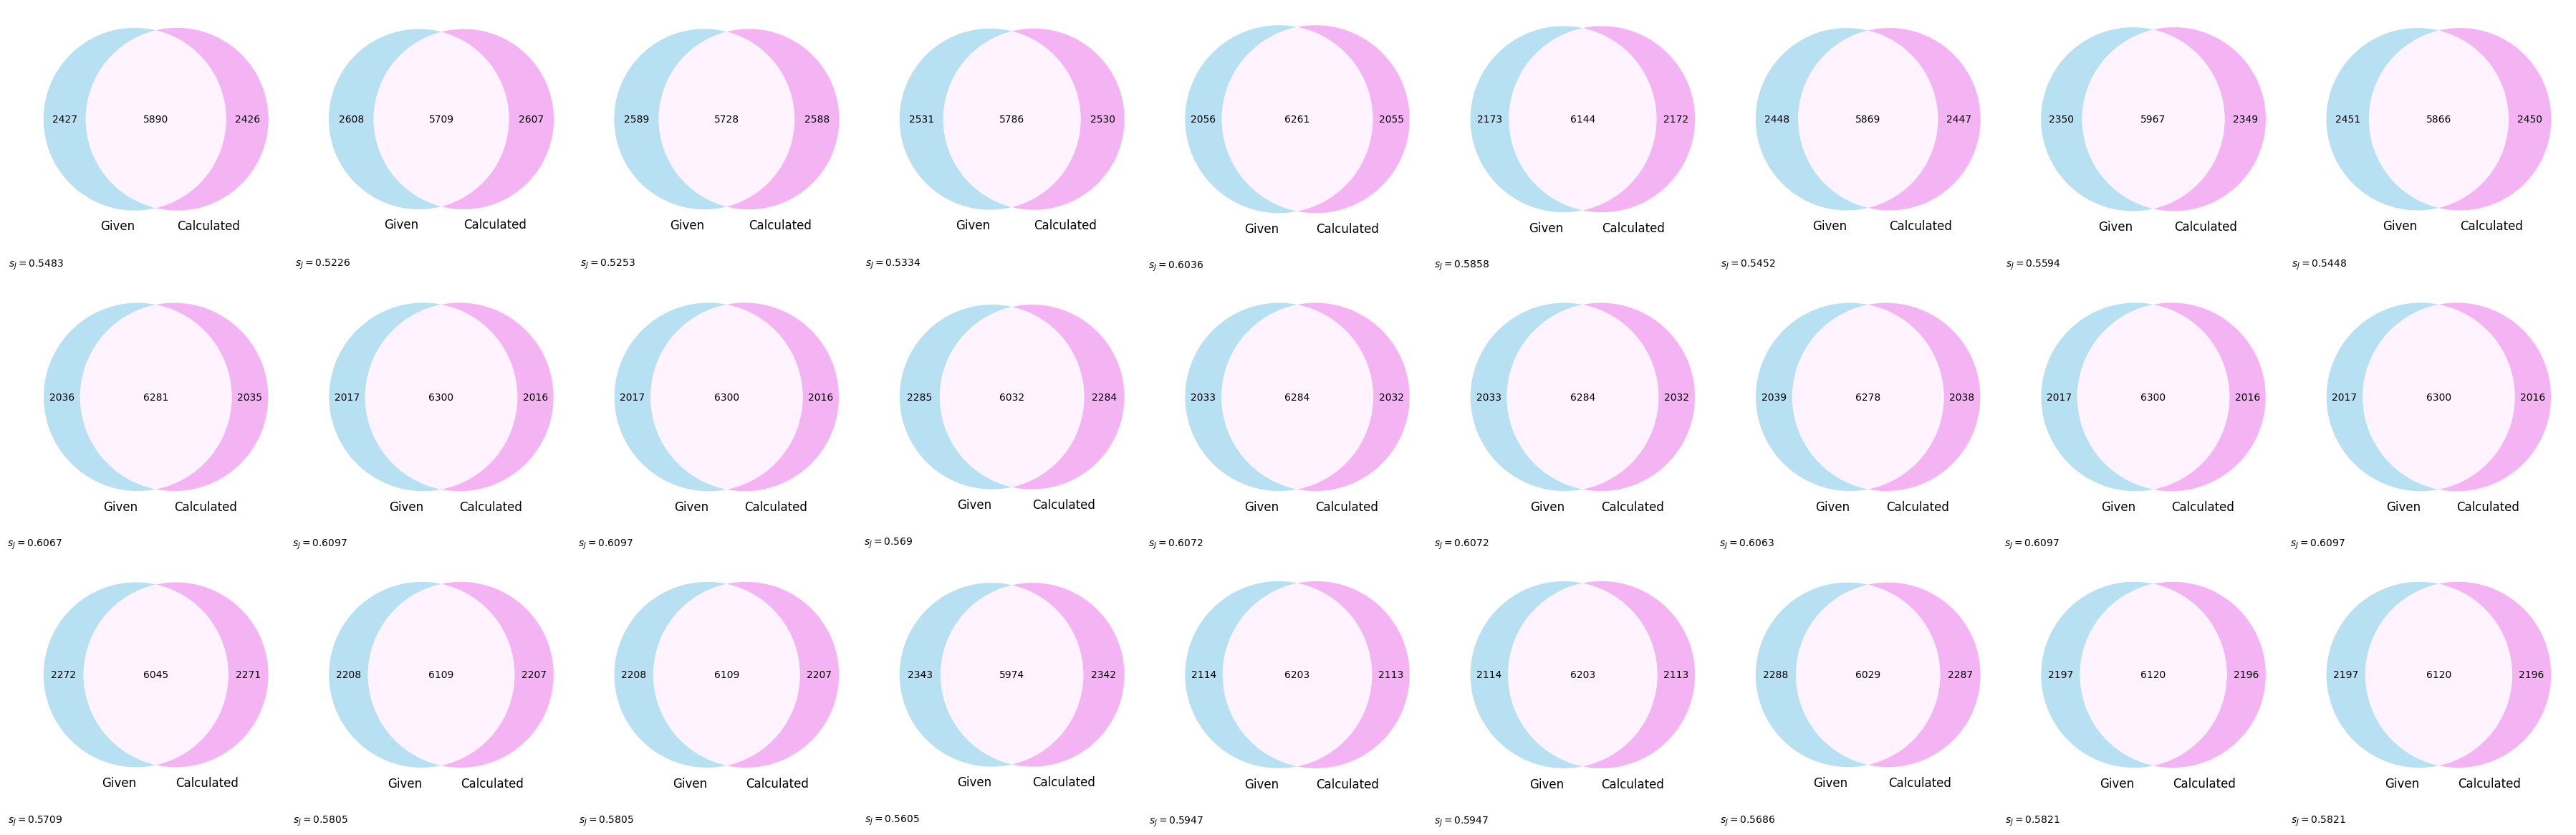

In [13]:
methods = ["norank", "min", "dense"]
heuristics = ["GAP", "SAP", "VAP"]
heuristics_dict = {"GAP":grad_scores, "SAP":mag_scores, "VAP": var_scores} 
gammas = [2, 1.5, 1, 0]
ratios = [0.125]*4
given_idcs = set(mask_list_to_idcs(given_mask))
maximum = float('-inf')
max_param = ""

fig, axarr = plt.subplots(nrows = 3, ncols = 9, figsize = (36, 12))

for i,(m_inst, m_sig) in enumerate([(a,b) for a in methods for b in methods]):
    inst_ranks = scores_to_global_ranks(inst_scores, method = m_inst)
    for j,h in enumerate(heuristics):
        sig_ranks = scores_to_global_ranks(heuristics_dict[h], method = m_sig)
        _, ordered_idcs = global_mask_from_ranks(inst_ranks, sig_ranks, gammas, ratios)
        sim = jaccard_similarity(set(ordered_idcs), given_idcs)
        venn2([given_idcs, set(ordered_idcs)], set_labels = ['Given', 'Calculated'], ax = axarr[j][i], set_colors=('skyblue', 'violet'), alpha = 0.6)

        axarr[j][i].text(s = r'$s_{J} = $'+str(round(sim, 4)), x = -0.8, y = -0.8, fontsize = 10)

        if maximum == sim:
            max_param += "\n" + m_inst + "\t\t" + m_sig + "\t\t" + h
            # portion of matching neurons
            print(len(set(ordered_idcs).intersection(given_idcs))/8317)
        if maximum < sim:
            maximum = sim
            max_param = m_inst + "\t\t" + m_sig + "\t\t" + h
        

print(f"max jaccard similarity {maximum:.4f} at params:\nINST_RANK\tSIG_RANK\tHEUR\n"+ max_param)
        
fig.tight_layout()
fig.show()


In [11]:
# Sanity check: portion of matching neurons for a randomly selected mask should be 50% and jaccard similarity value at 1/3
rand_mask = global_random_mask_from_ranks(grad_scores, ratios)
simi = jaccard_similarity(set(mask_list_to_idcs(given_mask)), set(mask_list_to_idcs(rand_mask)))
print(simi)
print(len(set(mask_list_to_idcs(rand_mask)).intersection(set(mask_list_to_idcs(given_mask))))/8317)

0.3256295824035703
0.4912829145124444
